# MagErrorSimulator() Demo (2)

__Author:__ Madison Ueland (@mueland)

__Created:__ 8/02/2021

__Last run:__ 8/05/2021

__Goals:__
We visualize the magnitude scatter simulated by MagErrorSimulator(). We validate the model by comparing to DC2 scatter from GCR Catalogs, as well as values quoted in _LSST: from Science Drivers to Reference Design and Anticipated Data Products_ (hereon referred to as Science Drivers).

__Before running__: 
Run the code in MagErrorSimulator() Demo (1) to load GCRCatalogs with the DESC kernel. 

__Dependencies:__
Run on NERSC with n2j virtual environment. To activate the environment and install it as a kernel in JupyterHub, run the following in terminal:
    
    source activate /global/common/software/m1727/n2j
    python -m ipykernel install --user --name n2j --display-name "Python (n2j)"


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['font.family'] = "sans-serif"
#plt.rcParams['font.sans-serif'] = "Arial"
%matplotlib inline

from scipy.stats import norm
from scipy.stats import median_abs_deviation

import os 
print(os.getcwd()) # make sure cwd is node-to-joy
# os.chdir('..')

from n2j.trainval_data.utils.transform_utils import MagErrorSimulator

/global/u1/u/ueland/node-to-joy


In [28]:
df = pd.read_pickle("../GCRCatalog_data.pkl") # the path to the .pkl file you created in Part (1)

df.head()

,cosmodc2_id_truth,mag_u_cModel,mag_u_truth,magerr_u_cModel,mag_g_cModel,mag_g_truth,magerr_g_cModel,mag_r_cModel,mag_r_truth,magerr_r_cModel,mag_i_cModel,mag_i_truth,magerr_i_cModel,mag_z_cModel,mag_z_truth,magerr_z_cModel,mag_y_cModel,mag_y_truth,magerr_y_cModel
0,9757893771,25.403819,25.040979,0.129801,25.008722,24.920948,0.041178,25.042115,24.890732,0.044431,25.055132,24.858370,0.077588,24.955879,24.619083,0.204164,24.868827,24.455359,0.399410
1,9755619494,26.661925,26.438885,0.485898,26.269268,26.565571,0.140656,26.446545,26.644583,0.185195,26.194918,26.527115,0.265715,26.285375,26.487595,0.794631,26.925919,25.965885,3.156536
2,9752138026,27.378007,27.212553,0.839420,27.376702,27.004620,0.338413,26.812035,26.575220,0.218456,25.852688,25.818033,0.161342,24.880547,25.414200,0.191969,25.434008,25.395538,0.742039
3,9750756795,27.349352,27.679865,1.169052,26.373768,26.292530,0.207011,25.014239,24.947500,0.056116,24.084178,24.091072,0.040529,23.462577,23.807713,0.072090,23.404635,23.602592,0.145046
4,9750164856,29.039567,28.124741,4.692849,26.466317,26.864693,0.193658,25.593136,25.809145,0.092514,25.200052,25.515120,0.106868,24.718435,25.341164,0.212958,24.908063,25.232611,0.500073


## Validating against DC2 _magerr_

Let's first compare the mag scatter generated using the default configurations of MagErrorSimulator() to _magerr_, the estimated photometric uncertainty of objects in the DC2 Object catalog. For each band, we plot a heatmap of the _magerr_ values (y axis) of objects with different true magnitudes (x axis). 

MagErrorSimulator() should align well, since we tuned the default sky brightness and seeing to match DC2. 

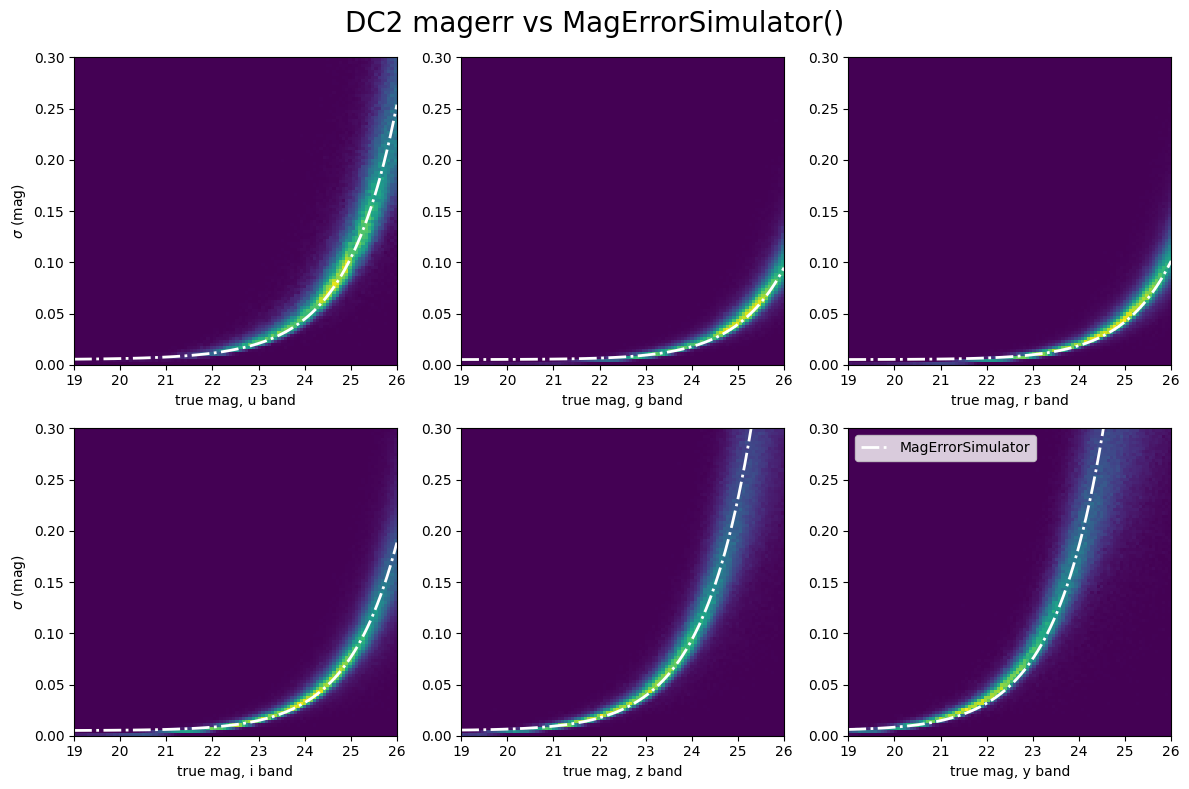

In [29]:
mes = MagErrorSimulator() # default - depth=5, airmass=1.15304, tuned sky brightness, seeing
bands = 'ugrizy'

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8), dpi=100)

mag_grid = np.linspace(19, 26, 100)
mags = mag_grid.reshape(-1, 1).repeat(6, axis = 1) # shape [100, 6]
errs = mes.get_sigmas(mags)  # shape [100, 6]


def plot(b, errs):
    band = bands[b]
    
    row = int(b>2)
    col = int(b%3)
    y = df[f'magerr_{band}_cModel']
    x = df[f'mag_{band}_truth']
    hist = ax[row][col].hist2d(x, y, bins=(100, 100), range = [[19, 26], [0, 0.3]], cmap=plt.cm.viridis)#, marker='.', alpha=0.2)
    
    ax[row][col].plot(mag_grid, errs[:,b], '-.', label = 'MagErrorSimulator', color='w', linewidth=2)
    
    ax[row][col].set_xlabel(f'true mag, {band} band')
    if col == 0:
        ax[row][col].set_ylabel('$\sigma$ (mag)')

    #fig.colorbar(hist, ax=ax[row][col])

for b in range(len(bands)):
    plot(b, errs)
    
fig.suptitle('DC2 magerr vs MagErrorSimulator()', fontsize=20)
plt.tight_layout()
#plt.colorbar(hist, ax=ax[1][2])

plt.legend()
plt.show()


You may wish to instantiate MagErrorSimulator() with different kwargs to compare the fit to DC2 _magerr_ with different observation conditions. This can be done by passing in _override_kwargs_, a dict of band-dependent parameters you wish to override, e.g. _m_skys_ (sky brightness), _seeings_, _k_ms_ (atmospheric extinction). 

This is done below using the sky brightness and seeing values from Table 2 of Science Drivers. Observe that the DC2 scatter is greater than that produced with MagErrorSimulator() using the Table 2 observation conditions, perhaps because MagErrorSimulator() relies on (optimistic?) static parameters rather than changing observation conditions. 

You may also wish to change _airmass_ from its default of 1.15304 (the median OpSim airmass). 

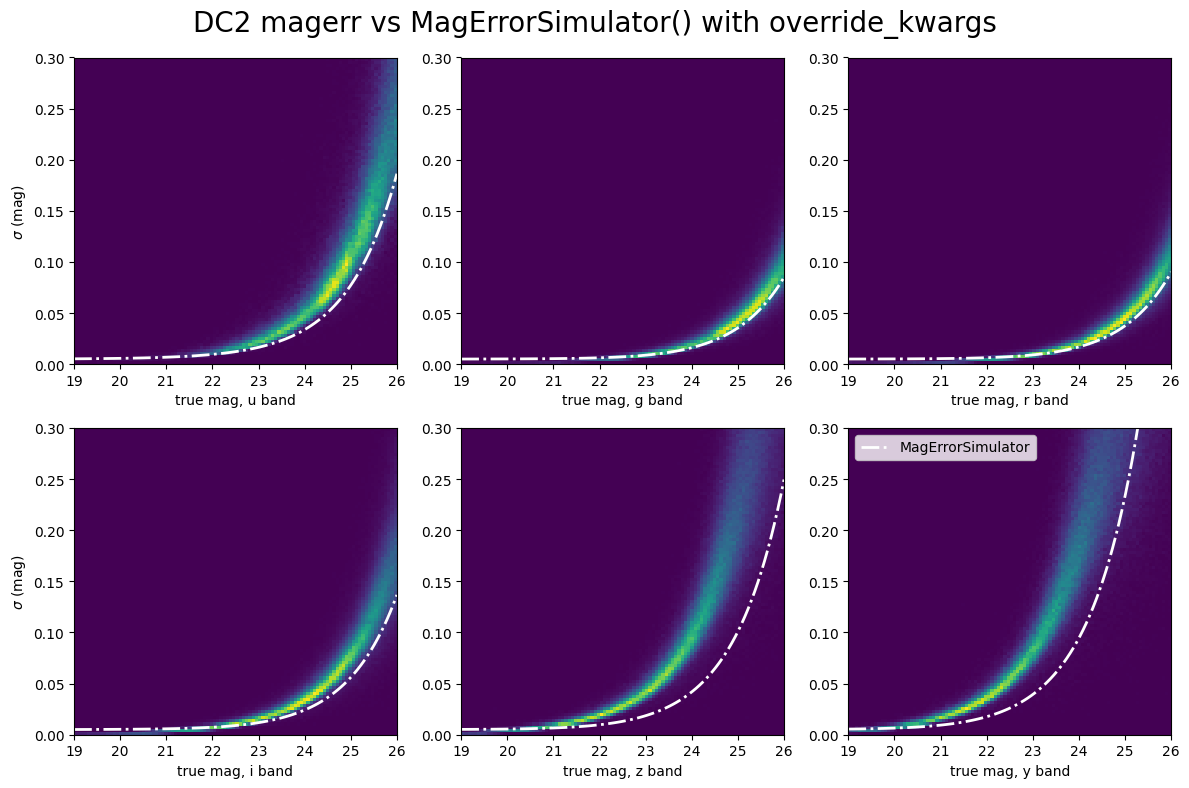

In [30]:
override_kwargs = {}
override_kwargs['m_skys'] = np.array([22.99, 22.26, 21.20, 20.48, 19.60, 18.61])
override_kwargs['seeings'] = np.array([0.92, 0.87, 0.83, 0.80, 0.78, 0.76])

airmass = 1.2 # airmass used in Science Drivers Table 2

mes2 = MagErrorSimulator(override_kwargs=override_kwargs, airmass=airmass) 
errs2 = mes2.get_sigmas(mags)  # shape [100, 6]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8), dpi=100)

for b in range(len(bands)):
    plot(b, errs2)
    
fig.suptitle('DC2 magerr vs MagErrorSimulator() with override_kwargs', fontsize=20)
plt.tight_layout()
#plt.colorbar(hist, ax=ax[1][2])

plt.legend()
plt.show()

## Validating against Science Drivers  

Here we compare MagErrorSimulator() scatter values in the r band to those in Science Drivers Table 3. 

MagErrorSimulator() scatter, tuned to DC2 _magerr_ above, exceeds the Science Drivers values at both single visit and 10 year depths, so the Table 3 values were probably based on optimistic observation conditions.

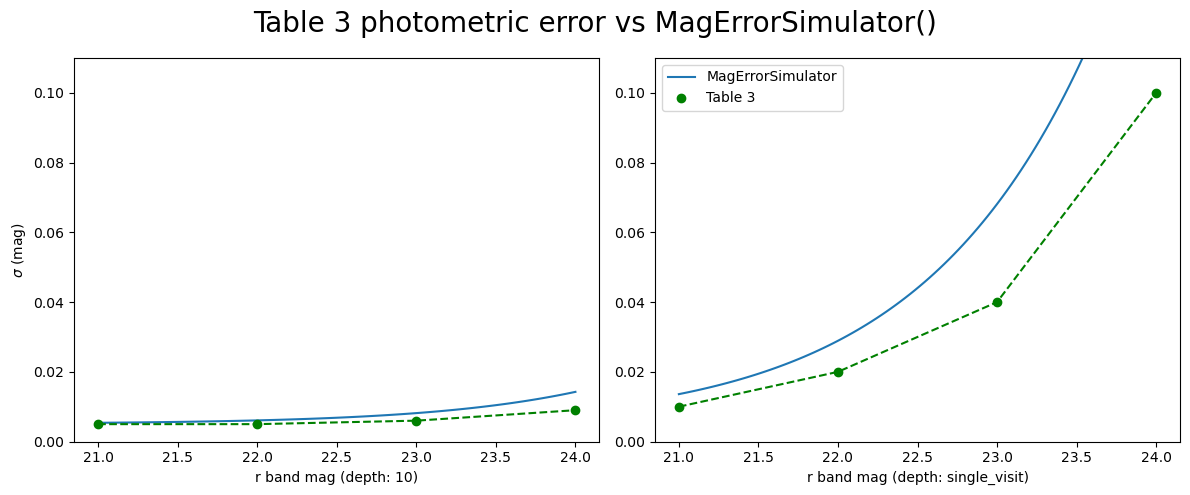

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), dpi=100)
depths = [10, 'single_visit']

airmass = 1.15304 # airmass used by MagErrorSimulator

Table_3_r_sigma = {}
Table_3_r_sigma['single_visit'] = [0.01, 0.02, 0.04, 0.10]
Table_3_r_sigma[10] = [0.005, 0.005, 0.006, 0.009]

mag_grid = np.linspace(21, 24, 100)
mags = mag_grid.reshape(-1, 1).repeat(6, axis = 1) # shape [100, 6]

r_idx = list('ugrizy').index('r')  # 2

def plot(col, depth):
    mes3 = MagErrorSimulator(depth=depth, airmass=airmass)
    
    ax[col].plot(mag_grid, mes3.get_sigmas(mags)[:, r_idx], label = 'MagErrorSimulator')

    x = np.arange(21, 25)
    y = Table_3_r_sigma[depth]
    xvals = mag_grid 
    yinterp = np.interp(xvals, x, y) 

    ax[col].plot(x, y, 'o', color='green', label = 'Table 3')
    ax[col].plot(xvals, yinterp, '--', color='green')

    ax[col].set_ylim(0, 0.11)
    ax[col].set_xlabel(f'r band mag (depth: {depth})')
    if col == 0:
        ax[col].set_ylabel('$\sigma$ (mag)')

for i in range(len(depths)):
    plot(i, depths[i])


plt.suptitle('Table 3 photometric error vs MagErrorSimulator()', fontsize=20)
plt.tight_layout()

plt.legend()
plt.show()


## Comparing to DC2 Measured Scatter

Returning to the DC2 Object catalog comparison, we now compare MagErrorSimulator() scatter to the difference between objects' observed minus true magnitudes. Interestingly, this measure of scatter (observed minus true magnitudes) exceeds the _magerr_ quantities.

Since we are plotting a histogram for a given magnitude bin, we first choose _chosen_mag_, the true magnitude at which to center our magnitude bin. 

In [23]:
chosen_mag = 23
bin_width = 0.1

First we plot the difference between cModel (observed) and true magnitudes. Since there are large tails, we choose to "prune" the distribution to remove outliers that have likely been mismatched. We do not want to attribute these large differences to photometric error. 

(Note that we must add the cModel (composite model) suffix to the observed magnitudes, otherwise the galaxies would be treated as point source objects, introducing a bias.)

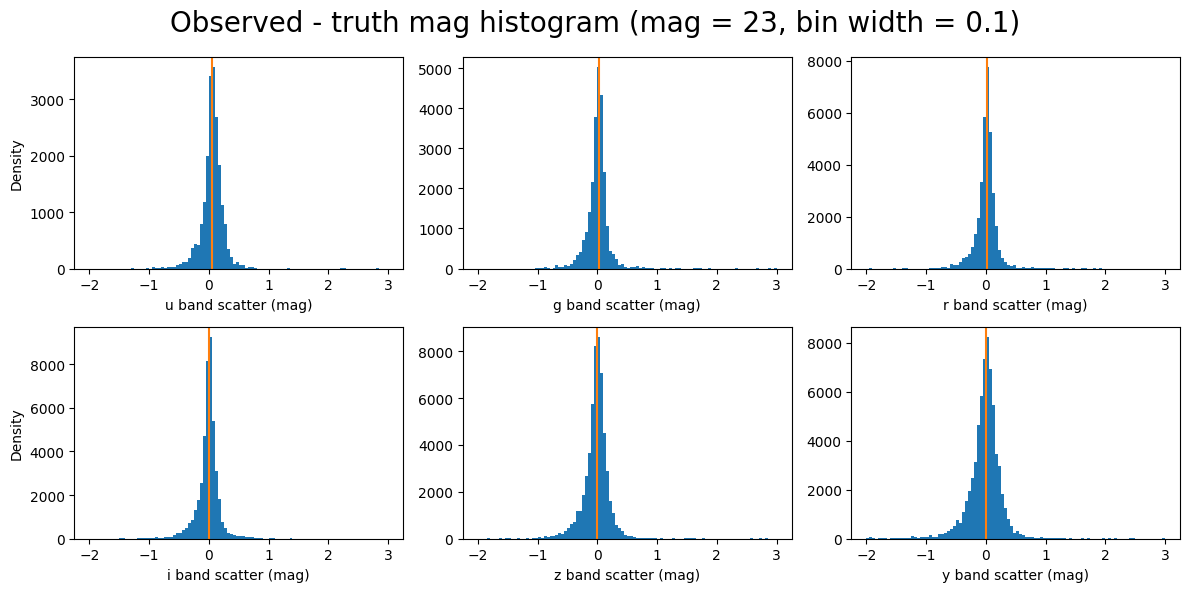

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,6), dpi=100)

bands = 'ugrizy'

def plot(b):
    band = bands[b]
    
    flter = (df[f'mag_{band}_truth'] > (chosen_mag - bin_width/2))&(df[f'mag_{band}_truth'] < (chosen_mag + bin_width/2))
    df_mag_cut = df[flter]
    
    row = int(b>2)
    col = int(b%3)

    ax[row][col].hist(df_mag_cut[f'mag_{band}_cModel'] - df_mag_cut[f'mag_{band}_truth'], bins=100, range=[-2, 3])
    
    ax[row][col].set_xlabel(f'{band} band scatter (mag)')
    if col == 0:
        ax[row][col].set_ylabel('Density')
        
    ax[row][col].axvline(np.median(df_mag_cut[f'mag_{band}_cModel'].values - df_mag_cut[f'mag_{band}_truth'].values), label='mean diff', color='tab:orange')

for b in range(len(bands)):
    plot(b)
    
fig.suptitle(f'Observed - truth mag histogram (mag = {chosen_mag}, bin width = {bin_width})', fontsize=20)
plt.tight_layout()
plt.show()


In [25]:
Observed_true_dif_medians = []
Observed_true_dif_stds = []
Observed_true_dif_mads = []
for band in bands:
    flter = (df[f'mag_{band}_truth'] > (chosen_mag - bin_width/2))&(df[f'mag_{band}_truth'] < (chosen_mag + bin_width/2))
    df_mag_cut = df[flter]
    
    # is there a better way to do this
    magdifs = df_mag_cut[f'mag_{band}_cModel'].values - df_mag_cut[f'mag_{band}_truth'].values 
    magdif_median = np.median(magdifs)
    magdif_std = np.std(magdifs)
    magdif_mad = median_abs_deviation(magdifs)
    
    Observed_true_dif_medians.append(magdif_median)
    Observed_true_dif_stds.append(magdif_std)
    Observed_true_dif_mads.append(magdif_mad)
    

print("Observed_true_dif_medians: " + str(Observed_true_dif_medians))
print("Observed_true_dif_stds: " + str(Observed_true_dif_stds))
print("Observed_true_dif_mads: " + str(Observed_true_dif_mads))

Observed_true_dif_medians: [0.06022645288409301, 0.020315898108780317, 0.01349563236511031, -0.0004032450745299343, -9.564258690808458e-05, 0.002096608986839499]
Observed_true_dif_stds: [0.2256834439671879, 0.31147250008998933, 0.2774626636702749, 0.289969865348337, 0.2825525987071742, 0.35260779314966156]
Observed_true_dif_mads: [0.0798958156158811, 0.07167647909952635, 0.06946975195456062, 0.07141388252050618, 0.09284795249358879, 0.11875742358014563]


Below we replot the histogram after removing outliers that have a magdif (observed magnitude minus true magnitude) greater than 3 median absolute deviations from the mean.

For each band, we fit a gaussian to this pruned distribution (black) and overlay another gaussian (yellow) with width corresponding to the sigmas returned by MagErrorSimulator() for _chosen_mag_. Since we are using the default MagErrorSimulator() kwargs that were tuned to DC2 _magerr_, this also corresponds to a comparison with _magerr_. 

Interestingly, with _chosen_mag_ = 24, the DC2 magdif sigmas are greater than the _magerr_ sigmas for all bands except z and y. There is also a bias with some of the DC2 magdif means, which are slightly negative.

__@JWP, any hypotheses here?__ 

DC2 std (u band) = 0.17224938064703907
MagErrorSimulator std (u band) = 0.020798775701450705
DC2 std (g band) = 0.13827016783377724
MagErrorSimulator std (g band) = 0.009392568322305457
DC2 std (r band) = 0.12838100401922423
MagErrorSimulator std (r band) = 0.009765103126582056
DC2 std (i band) = 0.12921993978913235
MagErrorSimulator std (i band) = 0.014905705578497581
DC2 std (z band) = 0.15890037884556274
MagErrorSimulator std (z band) = 0.03902633169201637
DC2 std (y band) = 0.195178190197412
MagErrorSimulator std (y band) = 0.07535012163312892


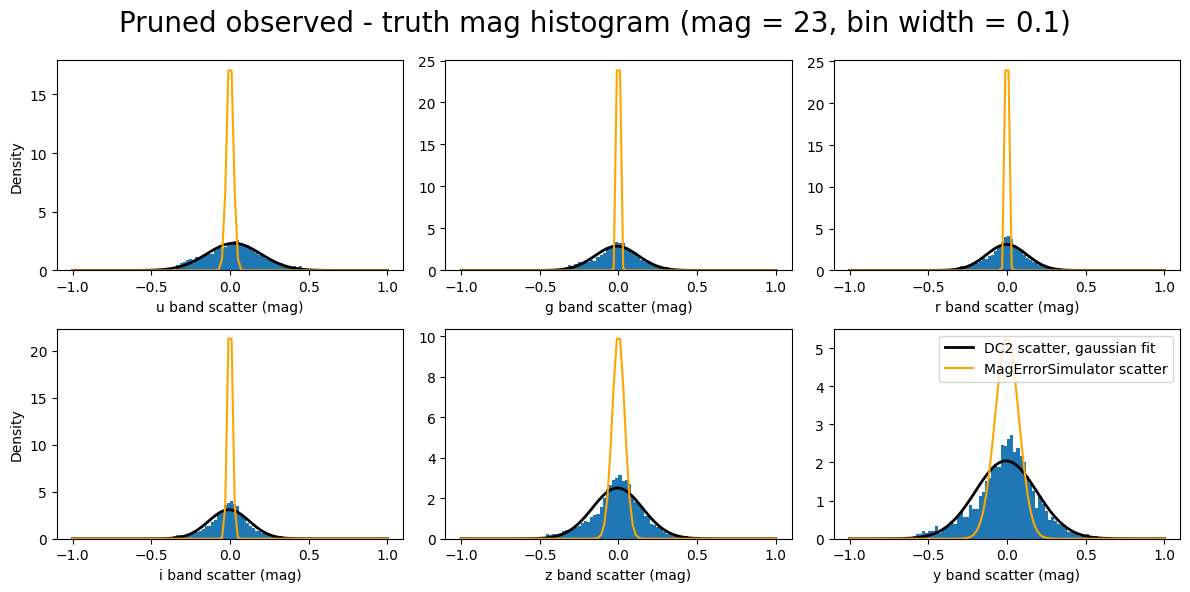

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,6), dpi=100)

bands = ['u', 'g', 'r', 'i', 'z', 'y']
analytic_sigmas = {}

mes = MagErrorSimulator() # default - depth=5, airmass=1.15304, tuned sky brightness, seeing
mags = np.full((1, 6), chosen_mag)
analytic_sigmas[chosen_mag] = np.squeeze(mes.get_sigmas(mags))

def plot(b):
    band = bands[b]
    
    """
    # pruning beyond 3 sigma
    magdifs = df_mag_cut[f'mag_{band}_cModel'].values - df_mag_cut[f'mag_{band}_truth'].values
    mu, sigma = norm.fit(magdifs)
    flter2 = np.abs(magdifs - mu) < (3*sigma)
    """
    # pruning beyond 3 mads
    i = 'ugrizy'.find(band)
    magdifs = df_mag_cut[f'mag_{band}_cModel'].values - df_mag_cut[f'mag_{band}_truth'].values
    mu = Observed_true_dif_medians[i]
    mad = Observed_true_dif_mads[i]
    flter2 = np.abs(magdifs - mu) < 5*mad
    
    
    #plotting
    row = int(b>2)
    col = int(b%3)
    pruned_data = df_mag_cut[flter2][f'mag_{band}_cModel'] - df_mag_cut[flter2][f'mag_{band}_truth']
    ax[row][col].hist(pruned_data, bins=100, range=[-1, 1], density=True)
    
    ax[row][col].set_xlabel(f'{band} band scatter (mag)')
    if col == 0:
        ax[row][col].set_ylabel('Density')
    #ax[row][col].axvline(np.median(df_mag_cut[flter][f'mag_{band}_cModel'].values - df_mag_cut[flter][f'mag_{band}_truth'].values), label='mean diff', color='tab:orange')


    mean, std = norm.fit(pruned_data)

    x = np.linspace(-1, 1, 100)
    p = norm.pdf(x, mean, std)
    ax[row][col].plot(x, p, 'k', linewidth=2, label = 'DC2 scatter, gaussian fit')
    #title = "Fit results: mu = %.2f,  std = %.2f" % (mean, std)
    p_analytic = norm.pdf(x, 0, analytic_sigmas[chosen_mag][b])
    ax[row][col].plot(x, p_analytic, 'orange', linewidth=1.5, label = 'MagErrorSimulator scatter')
    
    print(f"DC2 std ({band} band) = " + str(std))
    print(f"MagErrorSimulator std ({band} band) = " + str(analytic_sigmas[chosen_mag][b]))
                      
for b in range(len(bands)):
    plot(b)
    #print(int(i>2))
    
fig.suptitle(f'Pruned observed - truth mag histogram (mag = {chosen_mag}, bin width = {bin_width})', fontsize=20)
plt.tight_layout()
plt.legend()
plt.show()

## OpSim Validation

Here we load the OpSim database file used for DC2, used to mirror DC2 observation conditions in plots above (alongside some tuning of sky brightness and seeing). 

In [16]:
import os
import sqlite3
import pandas as pd
import numpy as np
# Example list of columns
columns = ['expMJD', 'expDate', 'visitTime', 'visitExpTime', 'obsHistID']
columns += ['fiveSigmaDepth', 'airmass']
columns += ['filtSkyBrightness', 'vSkyBright']
columns += ['filter', 'FWHMeff', 'rawSeeing']  # FWHMeff is the seeing
""" 
Here's the entire list of available columns
['obsHistID', 'sessionID', 'propID', 'fieldID', 'fieldRA', 'fieldDec', 'filter', 
'expDate', 'expMJD', 'night', 'visitTime', 'visitExpTime', 'finRank', 'FWHMeff', 
'FWHMgeom', 'transparency', 'airmass', 'vSkyBright', 'filtSkyBrightness', 'rotSkyPos', 
'rotTelPos', 'lst', 'altitude', 'azimuth', 'dist2Moon', 'solarElong', 'moonRA', 
'moonDec', 'moonAlt', 'moonAZ', 'moonPhase', 'sunAlt', 'sunAz', 'phaseAngle', 
'rScatter', 'mieScatter', 'moonIllum', 'moonBright', 'darkBright', 'rawSeeing', 
'wind', 'humidity', 'slewDist',  'slewTime', 'fiveSigmaDepth', 'ditheredRA', 
'ditheredDec', 'descDitheredDec', 'descDitheredRA', 'descDitheredRotTelPos']
"""
# Create a SQL connection
con = sqlite3.connect(os.path.join('/global/homes/u/ueland', 'minion_1016_desc_dithered_v4_trimmed.db'))
# Read database into a Pandas dataframe
df = pd.read_sql_query("SELECT {:s} FROM Summary".format(', '.join(columns)),
                       con)

In [17]:
print(np.median(df['airmass'].values)) # not airmass

1.15303915439


In [18]:
# 'visitExpTime' = 30 for all bands as expected

In [19]:
five_sigmas = []
my5sigmas = []

mes = MagErrorSimulator()
m_5s = np.squeeze(mes.calculate_5sigma_depths())
#print(m_5s)

for band in 'ugrizy':
    five_sigmas.append(np.median(df[df['filter']==band]['fiveSigmaDepth'].values))
    my5sigmas.append(m_5s[i])
print("DC2 five sigma depths: ", five_sigmas)
print("MagErrorSimulator() five sigma depths: ", my5sigmas)
print("Difference: ", [a - b for a, b in zip(my5sigmas, five_sigmas)])

# TO COMPARE

DC2 five sigma depths:  [23.3443870666, 24.6453178253, 24.136220378300003, 23.5586780822, 22.9826250722, 22.135184327250002]
MagErrorSimulator() five sigma depths:  [24.08507215002734, 24.08507215002734, 24.08507215002734, 24.08507215002734, 24.08507215002734, 24.08507215002734]
Difference:  [0.7406850834273406, -0.560245675272661, -0.05114822827266252, 0.52639406782734, 1.102447077827339, 1.9498878227773382]


In [20]:
seeing = []
for band in 'ugrizy':
    seeing.append(np.median(df[df['filter']==band]['FWHMeff'].values))
   
print(seeing)

rawseeing = []
for band in 'ugrizy':
    rawseeing.append(np.median(df[df['filter']==band]['rawSeeing'].values))
   
print(rawseeing)

# much larger FWHMeff seeing. But rawseeing is an idealized model, ignore it.

[1.029668, 0.951018, 0.8996875, 0.868422, 0.840263, 0.8486855]
[0.619461, 0.606181, 0.602109, 0.615534, 0.618299, 0.620117]


In [21]:
sky_brightness = []
for band in 'ugrizy':
    sky_brightness.append(np.median(df[df['filter']==band]['filtSkyBrightness'].values))
    #print(band, np.median(df[df['filter']==band]['vSkyBright'].values))

print(sky_brightness)

# only slightly different sky brightnesses
# most off in i, z, y


[22.7132942806, 22.1919144667, 21.101726522950003, 19.9396442508, 19.0023118536, 18.24634883895]
